# Introduction to Dataset 

The dataset consists of 10 000 data points stored as rows with 14 features in columns
UID: unique identifier ranging from 1 to 10000
product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise
torque [Nm]: torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values. 
tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.

The machine failure consists of five independent failure modes
tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 â€“ 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the toolâ€™s rotational speed is below 1380 rpm. This is the case for 115 data points.
power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail 

# Objetivo do Negócio



1 - Determinar se a máquina irá falhar
2 - Determinar qual o tipo de falha

# Data Understanding

In [103]:
# Data wrangling
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Models Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model evaluation
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

# Save model
import pickle

# Set output as pandas
from sklearn import set_config
set_config(transform_output="pandas")


In [104]:
## Upload df
df = pd.read_csv(r'C:\Users\eng.fitness69\Documents\predictive_maintenance\predictive_maintenance.csv')
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


In [105]:
# Verify if the data has duplicate values or null values.
data_duplicates = df.duplicated().sum()
data_null = df.isnull().sum().sum()

print("Total de dados duplicados: ", data_duplicates)
print("Total de dados faltantes/nulos: ", data_null)

Total de dados duplicados:  0
Total de dados faltantes/nulos:  0


In [106]:
## Verify the data structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [107]:
## Numeric features analysis
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [108]:
## Verify the proportion of column "Target"
df.Target.value_counts()

0    9661
1     339
Name: Target, dtype: int64

In [109]:
## Verify the proportion of column "Failure_type"
df['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

How can be see, we dont have proportion in the column "Failure_type" distribution.

# Data Preparation


In [110]:
## Rename the columns (dont needed, but i like change for my custom)

rename_columns = {
    
    'UDI':'ID',
    'Air temperature [K]': 'Air_temperature',
    'Process temperature [K]' : 'Process_temperature',
    'Rotational speed [rpm]' : 'Rotational_speed',
    'Torque [Nm]' : 'Torque',
    'Tool wear [min]' : 'Tool_wear',
    'Product ID' : 'Product_ID',
    'Failure Type': 'Failure_type'    
    
}

df.rename(rename_columns, axis = 1, inplace = True)

In [111]:
## Regarding to introduction of dataset, we don't need ID and Product_ID columns for us business objective, so lets remove this.

drop_columns = ["ID", "Product_ID"]

df.drop(drop_columns, axis = 1, inplace = True)

In [112]:
## Change de type of "Rotational_speed" and "Tool_wear" columns to "float"
df['Rotational_speed'] = df['Rotational_speed'].astype('float')
df['Tool_wear'] = df['Tool_wear'].astype('float')


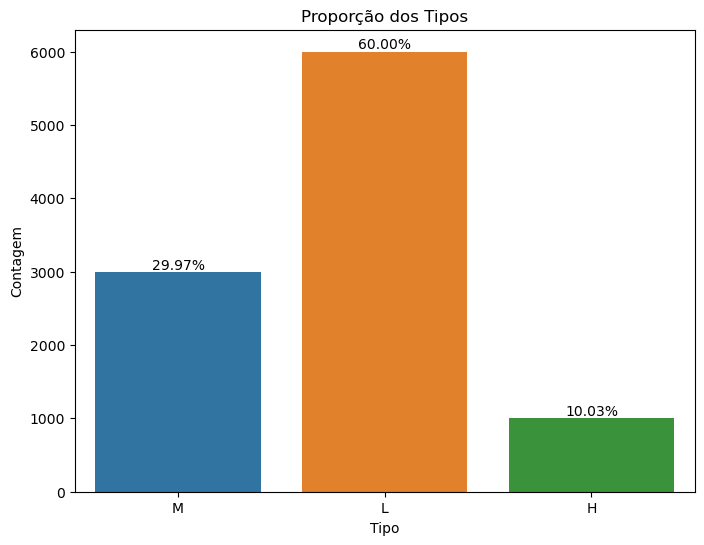

In [113]:
# Count types
tipo_contagem = df['Type'].value_counts()

# Show graphic
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='Type')
plt.title('Proporção dos Tipos')
plt.xlabel('Tipo')
plt.ylabel('Contagem')

# Add as percentages as labels
total = len(df['Type'])
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

plt.show()

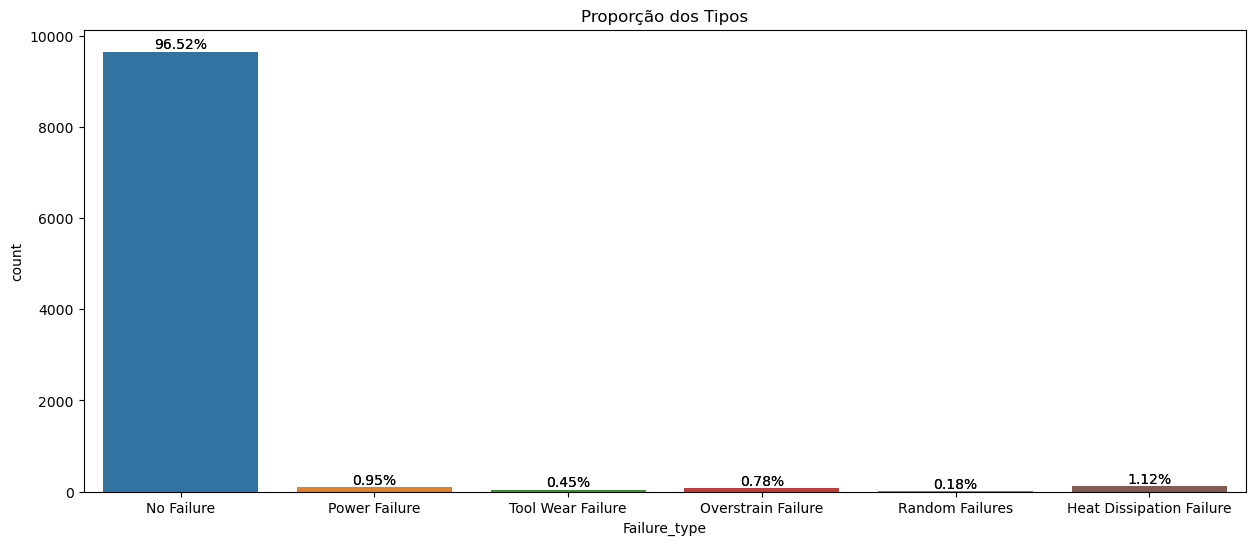

In [114]:
# Count types
tipo_contagem = df['Failure_type'].value_counts()

# Plot bar graphic
plt.figure(figsize=(15, 6))
ax = sns.countplot(data=df, x='Failure_type')
plt.title('Proporção dos Tipos')
plt.xlabel('Tipo')
plt.ylabel('Contagem')

ax = sns.countplot(data=df, x = 'Failure_type')

# Add as percentages as labels
total = len(df['Failure_type'])
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

plt.show()

How i've mencioned , we have a problem with this target column, the column hasn't proporcional distribution

In [115]:
# count failures on "Target" column
count_failures = (df['Target'] == 1).sum()
print('Número de falhas:', count_failures)

# Sum of occurrences of 'Failure_type' other than 'No Failure'
sum_failures = df.loc[(df['Failure_type'] != 'No Failure') & (df['Target'] == 1), 'Failure_type'].count()
print('Soma das falhas de tipo diferente de "No Failure":', sum_failures)


Número de falhas: 339
Soma das falhas de tipo diferente de "No Failure": 330


In [116]:
##9 data is ambiguous, so we need remove this.

# Filter the rows with has 1 in the column "Target" and 'No Failure' in the column 'Failure_type'
rows_to_remove = df[(df['Target'] == 1) & (df['Failure_type'] == 'No Failure')]

# Remove this filtered row in the main df
df.drop(rows_to_remove.index, inplace=True)


In [117]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9991 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Type                 9991 non-null   object 
 1   Air_temperature      9991 non-null   float64
 2   Process_temperature  9991 non-null   float64
 3   Rotational_speed     9991 non-null   float64
 4   Torque               9991 non-null   float64
 5   Tool_wear            9991 non-null   float64
 6   Target               9991 non-null   int64  
 7   Failure_type         9991 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 702.5+ KB


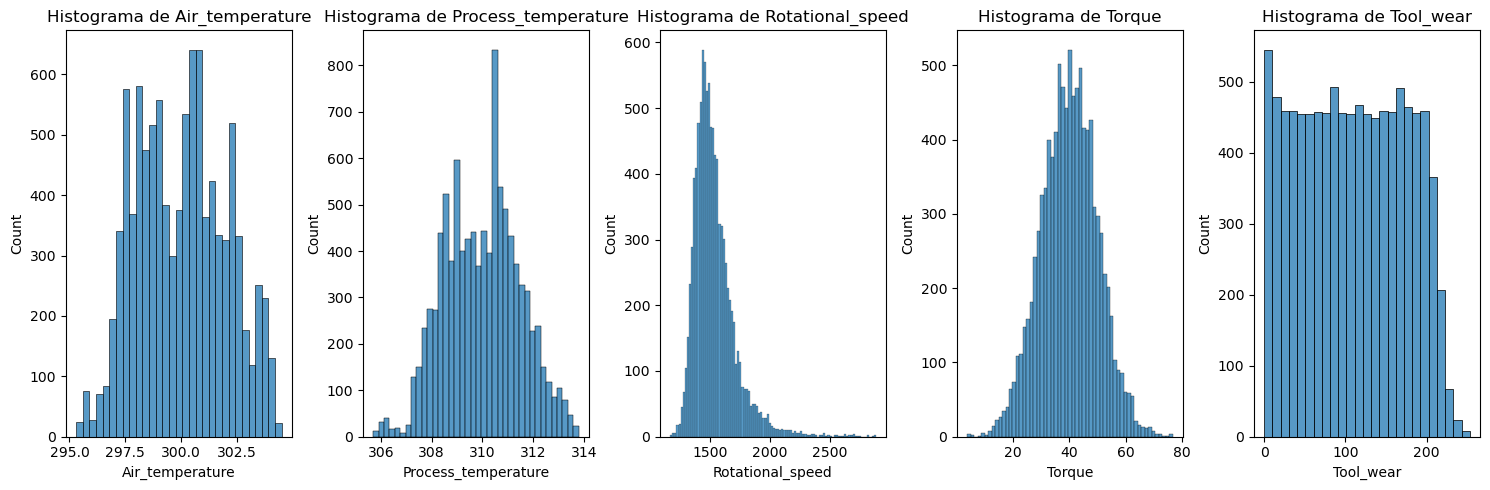

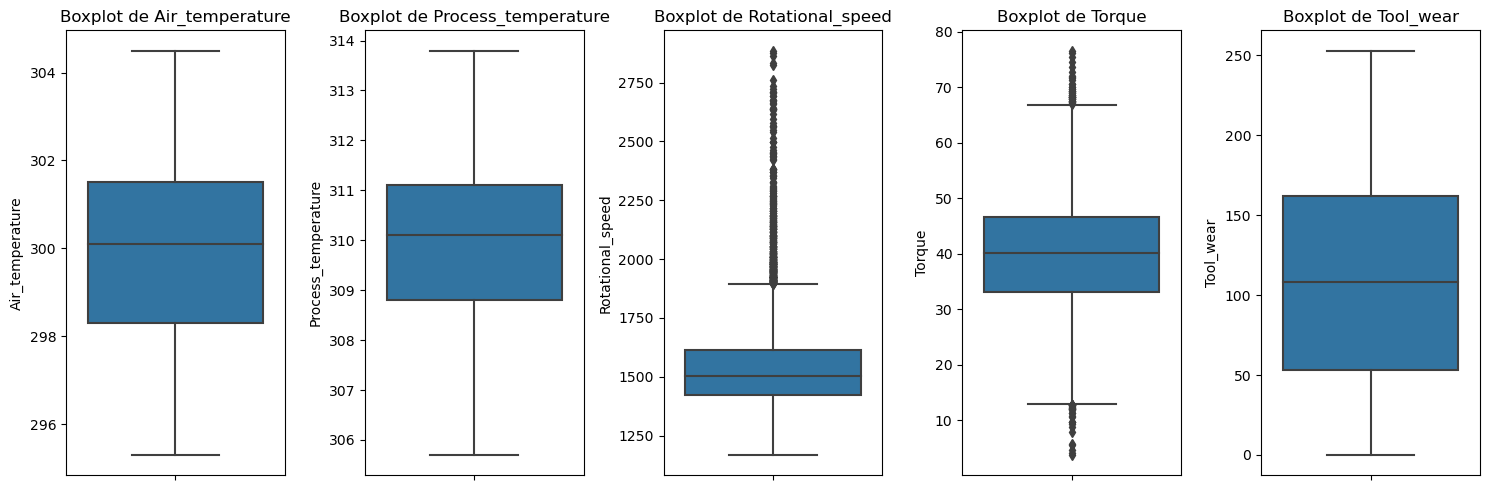

In [118]:
NUMERIC_FEATURES = ['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear']
CATEGORIC_FEATURES = ['Type']

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=len(NUMERIC_FEATURES), figsize=(15, 5))

# Plot histograms 
for i, feature in enumerate(NUMERIC_FEATURES):
    sns.histplot(data=df, x=feature, ax=axes[i])
    axes[i].set_title(f'Histograma de {feature}')

# Adjust subplot 
plt.tight_layout()

# Show histogram 
plt.show()

# Create the figure and axess
fig, axes = plt.subplots(nrows=1, ncols=len(NUMERIC_FEATURES), figsize=(15, 5))

# Plot boxplot side by side
for i, feature in enumerate(NUMERIC_FEATURES):
    sns.boxplot(data=df, y=feature, ax=axes[i])
    axes[i].set_title(f'Boxplot de {feature}')

# Adjust subplot
plt.tight_layout()

# Show boxplots
plt.show()



How can i see, maybe we have some outliers in the "Rotational_speed" and "Torque" columns, but we cant remove this now. Its necessary avaliate better.